In [1]:
#feature extraction for stock prediction
import numpy as np
import pandas_datareader.data as web
import pandas as pd
import pandas_ta as ta
import pandas_market_calendars as mcal
from dotenv import load_dotenv
from datetime import datetime, timedelta
import matplotlib
import matplotlib.pyplot as plt
import yfinance as yf
import os

load_dotenv()

QUANDL_API_KEY=os.getenv("QUANDL_API_KEY")
ALPHA_API_KEY=os.getenv("ALPHA_API_KEY")



In [2]:
NUM_OF_YEARS_PRED = 1 # num of year to predict
NUM_OF_YEARS_DATA = 5 # num of years of data to use

In [3]:
import requests
from bs4 import BeautifulSoup

def add_symbols_from_URL(URL='https://www.tradingview.com/markets/stocks-usa/market-movers-most-volatile/',companies = []):

    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    for row in soup.select('tbody tr'):
        if not row.find("td") == None:
            if not row.find("td").find("a") == None:
                #print(row.find("td").find("a").get_text())
                symbol = row.find("td").find("a").get_text()
                if symbol not in companies:
                    companies.append(row.find("td").find("a").get_text())

In [4]:
companies = []

In [5]:
f = open("S&P_Top50.txt", "r")
for lines in f:
    companies.append(lines.strip())

add_symbols_from_URL("https://www.tradingview.com/markets/stocks-usa/market-movers-most-volatile/",companies)
add_symbols_from_URL("https://www.tradingview.com/markets/stocks-usa/market-movers-gainers/",companies)
add_symbols_from_URL("https://www.tradingview.com/markets/stocks-usa/market-movers-losers/",companies)

In [6]:
#companies = ['AAPL','CSCO','GOOG']

In [7]:
import pandas_datareader.data as web
import pandas_market_calendars as mcal
import pandas_ta as ta
import pandas as pd

def creaet_outcomes(df:pd.DataFrame,year_pred:int,date:datetime):
    outcome_out = df.sort_index().copy()
    outcome_out.set_index((outcome_out["date"]),inplace=True)

    end_date =  outcome_out.index[-1]
    start_date = end_date.replace(year=end_date.year-year_pred)
    
    days_shift = (end_date - start_date).days

    outcome_out = outcome_out.sort_index()[date:]

    return outcome_out


def create_outcome(df:pd.DataFrame,year_pred:int,date:datetime):

    outcome_out = df.sort_index().copy()
    outcome_out.drop(columns=df.columns.difference(['date','symbol']),inplace=True)
    outcome_out.set_index(pd.DatetimeIndex(outcome_out["date"]),inplace=True)
    end_date =  df.index[-1]
    start_date = end_date.replace(year=end_date.year-year_pred)
    days_shift = (end_date - start_date).days

    outcome_colums = df.columns.difference(['date','symbol'])

    for i in range(1,days_shift+1):
        outcome = df[outcome_colums].shift(-i).add_suffix('_f'+str(i))
        outcome_out = pd.concat([outcome_out,outcome],axis=1)
    
    outcome_out = outcome_out[:date]
        
    return outcome_out


def create_indicators(df:pd.DataFrame):
    features = df.sort_index().copy()

    features.set_index((features["date"]),inplace=True)

    features.ta.strategy("all",exclude=["mcgd"],lookahead=False)
    features.ta.cdl_pattern(name="all", lookahead=False)

    features.drop(['open','high','low','close','volume'],axis=1,inplace=True)
    
    features.replace([np.inf, -np.inf], np.nan , inplace=True)
    for col in features.columns.difference(['date','symbol']): # fill nans
        features[col].interpolate(method="time",limit_direction="both",inplace=True)
        #features[col].interpolate(method="time",limit_direction="both",inplace=True)
    features.fillna(method='ffill',inplace=True)
         
    return features


def get_symbols(symbols,year_pred=NUM_OF_YEARS_PRED, year_data=NUM_OF_YEARS_DATA, data_source=None, begin_date=None,end_date=None):

    end_date = datetime.now().date() # to make sure we get todays data
    start_date = end_date.replace(year=end_date.year-year_pred-year_data)

    data_days = (end_date - start_date).days

    nyse = mcal.get_calendar('NYSE')
    dates = nyse.valid_days(start_date, end_date)

    while len(dates) <= data_days:
        if len(dates) == data_days:
            break
        start_date = start_date + timedelta(days=len(dates)-data_days)
        dates = nyse.valid_days(start_date, end_date)
    
    start_date = dates[0].date()
    end_date = dates[-1].date()

    days_shift = (end_date - end_date.replace(year=end_date.year-year_pred)).days

    print("Date Range" , start_date, " : " ,end_date)
    print("Feature Range ", start_date, " : ", dates[-days_shift-1].date())
    print("Outcome Range ", dates[-days_shift].date(), " : ", end_date)
    print()

    prices_out = pd.DataFrame()
    features_out = pd.DataFrame()
    outcome_out = pd.DataFrame()
    outcomes_out = pd.DataFrame()
    for symbol in symbols:
        if "." in symbol:
            continue

        ticker  = yf.Ticker(symbol)

        if ticker.info is None:
            continue

        df = ticker.history(start=start_date,interval='1d', auto_adjust=True)[['Open','High','Low','Close','Volume']].reset_index()     
        
        df.columns = ['date','open','high','low','close','volume']
        df['symbol'] = symbol

        if not df.date[0].date() == start_date:
            print("Not Enough Data For: ", symbol)
            continue
        
        #df['date'] = pd.to_datetime(df['date'])
        df = df.set_index(df['date'])
        
        outcome = create_outcome(df,year_pred,dates[-days_shift])
        outcomes = creaet_outcomes(df,year_pred,dates[-days_shift])
        df = df[:dates[-days_shift]]
        features = create_indicators(df)

        df = df.set_index(['date','symbol'])
        features = features.set_index(['date','symbol'])
        outcome = outcome.set_index(['date','symbol'])
        outcomes = outcomes.set_index(['date','symbol'])

        prices_out = pd.concat([prices_out,df],axis=0)
        features_out = pd.concat([features_out,features],axis=0)
        outcome_out = pd.concat([outcome_out,outcome],axis=0)
        outcomes_out = pd.concat([outcomes_out,outcomes],axis=0)

        print("Done Processing : ", symbol)
        

    return prices_out.sort_index(), features_out.sort_index(), outcome_out.sort_index(), outcomes_out.sort_index()

In [8]:
import pandas_datareader.data as web
import pandas_ta as ta

prices, indicators_features, outcomes, outcomes_table = get_symbols(companies,data_source='yahoo')
indicators_features.sort_index()

Date Range 2015-06-25  :  2024-03-11
Feature Range  2015-06-25  :  2022-09-23
Outcome Range  2022-09-26  :  2024-03-11

Done Processing :  MSFT
Done Processing :  AAPL
Done Processing :  GOOG
Done Processing :  AMZN
Done Processing :  NVDA
Done Processing :  GOOGL
Done Processing :  LLY
Done Processing :  TSLA
Done Processing :  AVGO
Done Processing :  JPM
Done Processing :  UNH
Done Processing :  WMT
Done Processing :  V
Done Processing :  MA
Done Processing :  XOM
Done Processing :  JNJ
Done Processing :  PG
Done Processing :  HD
Done Processing :  MRK
Done Processing :  COST
Done Processing :  ABBV
Done Processing :  ORCL
Done Processing :  CVX
Done Processing :  CRM
Done Processing :  BAC
Done Processing :  AMD
Done Processing :  KO
Done Processing :  NFLX
Done Processing :  ADBE
Done Processing :  PEP
Done Processing :  ACN
Done Processing :  TMO
Done Processing :  MCD
Done Processing :  ABT
Done Processing :  DIS
Done Processing :  CSCO
Done Processing :  TMUS
Done Processing :  

ABER_ZG_5_15  ABER_SG_5_15  ABER_XG_5_15  \
date                      symbol                                             
2015-06-25 00:00:00-04:00 AAPL       28.493449     29.084836     28.124973   
                          ABBV       47.415620     49.372712     47.628637   
                          ABT        41.891352     43.071427     41.718994   
                          ACN        85.264400     88.712058     85.681915   
                          ADBE       82.219332     83.202667     80.697333   
...                                        ...           ...           ...   
2022-09-23 00:00:00-04:00 WAVD        9.226667     10.640683      7.812651   
                          WFC        40.693460     41.914054     39.472866   
                          WFCF        9.422667      9.977421      8.867912   
                          WMT        43.641320     44.549405     42.733235   
                          XOM        86.314873     89.109607     83.520138   

                                  ABER_ATR_5_15   ACCBL_20   ACCBM_20  \
date                      symbol                                        
2015-06-25 00:00:00-04:00 AAPL         0.479931  27.356837  28.438469   
                          ABBV         0.872038  46.063958  47.900299   
                          ABT          0.676217  40.681615  42.286839   
                          ACN          1.515072  82.875705  86.156531   
                          ADBE         1.252667  78.783032  81.376000   
...                                         ...        ...        ...   
2022-09-23 00:00:00-04:00 WAVD         1.414016   8.366661  11.105000   
                          WFC          1.220594  38.854915  41.720030   
                          WFCF         0.554754   8.966236  10.074000   
                          WMT          0.908085  41.735094  43.819095   
                          XOM          2.794734  84.307564  89.882625   

                                   ACCBU_20            AD    ADOSC_3_10  \
date                      symbol                                          
2015-06-25 00:00:00-04:00 AAPL    29.549196 -1.277524e+08 -1.200592e+08   
                          ABBV    49.829925 -1.703936e+05 -1.849018e+06   
                          ABT     43.898693 -2.996354e+06 -5.278269e+05   
                          ACN     89.598112 -2.610031e+06 -1.466391e+06   
                          ADBE    84.268030  4.697183e+05 -2.853963e+06   
...                                     ...           ...           ...   
2022-09-23 00:00:00-04:00 WAVD    14.516660 -3.735716e+04 -9.419077e+03   
                          WFC     44.772277 -7.437352e+08 -9.990642e+06   
                          WFCF    11.371236  2.768669e+05 -6.805861e+03   
                          WMT     46.059255 -9.197971e+08 -1.082220e+07   
                          XOM     95.990719  1.610826e+08 -1.612487e+07   

                                     ADX_14  ...   VIDYA_14   VTXP_14  \
date                      symbol             ...                        
2015-06-25 00:00:00-04:00 AAPL    30.911813  ...   0.193898  0.829959   
                          ABBV    17.358251  ...   0.458420  0.933871   
                          ABT     28.260907  ...   0.578389  0.966545   
                          ACN     31.486634  ...   1.815736  0.984281   
                          ADBE    24.813999  ...   2.345925  0.866020   
...                                     ...  ...        ...       ...   
2022-09-23 00:00:00-04:00 WAVD    17.106858  ...   1.090743  0.785714   
                          WFC     14.525587  ...  41.451787  0.855021   
                          WFCF    34.600054  ...  10.473204  0.732629   
                          WMT     12.243881  ...  43.247856  0.835000   
                          XOM     12.411698  ...  88.386374  0.727992   

                                   VTXM_14     VWAP_D    VWMA_10        WCP  \
date                      symbol                                

In [9]:
prices.sort_index()

open       high        low      close  \
date                      symbol                                               
2015-06-25 00:00:00-04:00 AAPL    29.034668  29.111276  28.728233  28.728233   
                          ABBV    48.044535  48.534151  47.782488  48.147976   
                          ABT     42.086890  42.273376  41.773250  41.815636   
                          ACN     86.922876  87.148404  86.012103  86.289673   
                          ADBE    83.820000  84.269997  83.489998  83.940002   
...                                     ...        ...        ...        ...   
2022-09-23 00:00:00-04:00 WAVD     9.000000   9.000000   7.900000   8.000000   
                          WFC     39.053624  39.206700  37.982090  38.661366   
                          WFCF     8.910000   8.950000   8.510000   8.650000   
                          WMT     43.460765  43.562163  42.119684  42.541634   
                          XOM     83.162619  83.162619  80.643978  81.499367   

                                     volume  
date                      symbol             
2015-06-25 00:00:00-04:00 AAPL    127752400  
                          ABBV      6191200  
                          ABT       3607900  
                          ACN       5103200  
                          ADBE      3052900  
...                                     ...  
2022-09-23 00:00:00-04:00 WAVD         8560  
                          WFC      23316200  
                          WFCF        15500  
                          WMT      27195300  
                          XOM      27738800  

[209990 rows x 5 columns]

In [10]:
outcomes.sort_index()

close_f1    high_f1     low_f1    open_f1  \
date                      symbol                                               
2015-06-25 00:00:00-04:00 AAPL    28.559240  28.838636  28.505164  28.766534   
                          ABBV    48.589321  48.685865  48.051433  48.237623   
                          ABT     42.358128  42.366603  41.764757  41.934292   
                          ACN     85.873329  87.044328  85.456971  86.714715   
                          ADBE    82.739998  84.220001  82.269997  84.220001   
...                                     ...        ...        ...        ...   
2022-09-23 00:00:00-04:00 WAVD     9.000000   9.700000   7.200000   7.700000   
                          WFC     38.278679  38.785747  37.637673  38.403055   
                          WFCF     8.650000   8.900000   8.510000   8.650000   
                          WMT     42.950500  43.221985  41.956141  42.113145   
                          XOM     79.817093  81.946053  79.731550  80.691487   

                                    volume_f1   close_f2    high_f2  \
date                      symbol                                      
2015-06-25 00:00:00-04:00 AAPL    176267200.0  28.059031  28.496151   
                          ABBV      9669500.0  46.327427  48.285893   
                          ABT       6780500.0  41.544373  42.256417   
                          ACN       4990400.0  83.860924  85.934026   
                          ADBE      5914700.0  81.279999  82.059998   
...                                       ...        ...        ...   
2022-09-23 00:00:00-04:00 WAVD         3930.0   9.200000   9.700000   
                          WFC      21420000.0  38.297813  38.833582   
                          WFCF        12800.0   9.110000   9.310000   
                          WMT      23011200.0  42.832748  43.643935   
                          XOM      22043400.0  81.489845  82.649371   

                                     low_f2    open_f2    volume_f2  ...  \
date                      symbol                                     ...   
2015-06-25 00:00:00-04:00 AAPL    28.047766  28.268578  196645600.0  ...   
                          ABBV    46.258468  47.768691   12057200.0  ...   
                          ABT     41.501990  41.993641    5364300.0  ...   
                          ACN     83.739487  85.127337    3025000.0  ...   
                          ADBE    81.150002  81.220001    4060300.0  ...   
...                                     ...        ...          ...  ...   
2022-09-23 00:00:00-04:00 WAVD     9.000000   9.000000       1380.0  ...   
                          WFC     37.704643  38.470025   17541400.0  ...   
                          WFCF     8.750000   8.790000      13100.0  ...   
                          WMT     42.620138  43.251426   17171700.0  ...   
                          XOM     80.605945  81.366292   17307300.0  ...   

                                  close_f364   high_f364    low_f364  \
date                      symbol                                       
2015-06-25 00:00:00-04:00 AAPL     25.536983   25.581132   25.292999   
                          ABBV     43.279030   43.694124   42.929477   
                          ABT      33.286648   33.444738   33.023162   
                          ACN     104.909821  105.768490  103.908036   
                          ADBE     99.730003  100.150002   98.000000   
...                                      ...         ...         ...   
2022-09-23 00:00:00-04:00 WAVD      2.330000    2.370000    2.010000   
                          WFC      57.000000   57.680000   56.869999   
                          WFCF     12.690000   12.690000   11.930000   
                          WMT      60.360001   61.070000   60.349998   
                          XOM     107.370003  107.980003  106.599998   

                                   open_f364  volume_f364  close_f365  \
date                      symbol                                       

In [11]:
outcomes_table.sort_index()

open        high         low  \
date                      symbol                                       
2022-09-26 00:00:00-04:00 AAPL    148.392306  152.467493  148.372472   
                          ABBV    133.908152  134.586742  132.051457   
                          ABT      97.283994   97.740409   96.390592   
                          ACN     251.959822  256.178007  251.002903   
                          ADBE    286.029999  288.899994  276.750000   
...                                      ...         ...         ...   
2024-03-11 00:00:00-04:00 WAVD      2.300000    3.210000    2.300000   
                          WFC      56.779999   57.349998   56.520000   
                          WFCF     12.060000   12.060000   11.430000   
                          WMT      60.099998   60.709999   59.869999   
                          XOM     108.250000  109.120003  107.339996   

                                       close    volume  
date                      symbol                        
2022-09-26 00:00:00-04:00 AAPL    149.492905  93339400  
                          ABBV    133.088196   5697800  
                          ABT      96.953819   6037800  
                          ACN     251.471603   2349800  
                          ADBE    276.959991   6746200  
...                                      ...       ...  
2024-03-11 00:00:00-04:00 WAVD      2.810000    230800  
                          WFC      57.090000  16620000  
                          WFCF     11.430000      2600  
                          WMT      60.660000  14128800  
                          XOM     109.019997  17571700  

[42089 rows x 5 columns]

In [32]:
features = pd.DataFrame(index=prices.index).sort_index()
features['f01'] = prices.close/prices.open-1 # daily return
features['f02'] = prices.open/prices.groupby(level='symbol', group_keys=False).close.shift(1)-1 
features['f03'] = prices.volume.apply(np.log) # log of daily volume
features['f04'] = prices.groupby(level='symbol', group_keys=False).volume.diff() # change since prior day
features['f05'] = prices.groupby(level='symbol', group_keys=False).volume.diff(50) # change since 50 days prior
pct_chg_fxn = lambda x: x.pct_change()
features['f06'] = prices.groupby(level='symbol', group_keys=False).volume.apply(pct_chg_fxn) # rate of change
# exponential moving avg of daily volume
# log of 5 day moving average of volume
ma_5 = lambda x: x.rolling(5).mean()
features['f07'] = prices.volume.groupby(level='symbol', group_keys=False).apply(ma_5).apply(np.log) 
# daily closing price vs. 10 day 
ema_10 = lambda x: x.ewm(span=10).mean()
features['f08'] = prices.close/ prices.close.groupby(level='symbol', group_keys=False).apply(ema_10)-1
# daily volume vs. 20 day moving average
ma_20 = lambda x: x.rolling(20).mean()
features['f09'] = prices.volume/ prices.volume.groupby(level='symbol', group_keys=False).apply(ma_20)-1
# daily volume vs. 40 day moving average
ma_40 = lambda x: x.rolling(40).mean()
features['f10'] = prices.volume/ prices.volume.groupby(level='symbol', group_keys=False).apply(ma_40)-1
# daily volume vs. 80 day moving average
ma_80 = lambda x: x.rolling(80).mean()
features['f11'] = prices.volume/ prices.volume.groupby(level='symbol', group_keys=False).apply(ma_80)-1
# daily volume vs. 160 day moving average
ma_160 = lambda x: x.rolling(160).mean()
features['f12'] = prices.volume/ prices.volume.groupby(level='symbol', group_keys=False).apply(ma_160)-1
# daily volume vs. 320 day moving average
ma_320 = lambda x: x.rolling(320).mean()
features['f12'] = prices.volume/ prices.volume.groupby(level='symbol', group_keys=False).apply(ma_320)-1

zscore_fun = lambda x: (x - x.rolling(window=200, min_periods=20).mean()) / x.rolling(window=200, min_periods=20).std()
features['f13'] =prices.groupby(level='symbol', group_keys=False).close.apply(zscore_fun)

rollrank_fxn = lambda x: x.rolling(200,min_periods=20).apply(lambda x: pd.Series(x).rank(pct=True)[0])
features['f14'] = prices.groupby(level='symbol', group_keys=False).volume.apply(rollrank_fxn)

features['f15'] = features['f11'].dropna().groupby(level='date').rank(pct=True) 
features['f16'] = features['f12'].dropna().groupby(level='date').rank(pct=True)

# money flow index (14 day)
features['f17'] = ta.volume.mfi(prices.high, prices.low, prices.close,prices.volume, window=14, fillna=False).astype(float)
# mean-centered money flow index
features['f18'] = features['f13'] - features['f13'].rolling(200,min_periods=20).mean()

#features.replace([np.inf, -np.inf], np.nan, inplace=True)
#n_bins = 10
#bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
#features['f19'] = prices.volume.groupby(level='symbol', group_keys=False).apply(bin_fxn)

features['f20'] = features['f06'].apply(np.sign)

plus_minus_fxn = lambda x: x.rolling(20).sum()
features['f21'] = features['f20'].groupby(level='symbol', group_keys=False).apply(plus_minus_fxn)

features['f22'] = prices.close.pct_change()
features['f23'] = np.where(prices.volume.shift(-1) > prices.volume, 1, 0)

month_of_year = prices.index.get_level_values(level='date').month
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_year, dtype=int))
one_hot_frame.index = prices.index

# create column names 
feat_names = ['month_'+str(num) for num in list(range(1,1+12))]

# rename columns and merge
one_hot_frame.columns = feat_names

features = features.join(one_hot_frame)

features.replace([np.inf, -np.inf], np.nan, inplace=True)

features

f01       f02        f03         f04  \
date                      symbol                                              
2015-06-25 00:00:00-04:00 AAPL   -0.010554       NaN  18.665605         NaN   
                          ABBV    0.002153       NaN  15.638639         NaN   
                          ABT    -0.006445       NaN  15.098636         NaN   
                          ACN    -0.007285       NaN  15.445378         NaN   
                          ADBE    0.001432       NaN  14.931603         NaN   
...                                    ...       ...        ...         ...   
2022-09-23 00:00:00-04:00 WAVD   -0.111111  0.200000   9.054855    -10280.0   
                          WFC    -0.010044 -0.016859  16.964659   7817200.0   
                          WFCF   -0.029181 -0.037797   9.648595     11000.0   
                          WMT    -0.021149 -0.003898  17.118555  10450800.0   
                          XOM    -0.020000 -0.033896  17.138343  11599400.0   

                                        f05       f06        f07       f08  \
date                      symbol                                             
2015-06-25 00:00:00-04:00 AAPL          NaN       NaN        NaN  0.000000   
                          ABBV          NaN       NaN        NaN  0.000000   
                          ABT           NaN       NaN        NaN  0.000000   
                          ACN           NaN       NaN        NaN  0.000000   
                          ADBE          NaN       NaN        NaN  0.000000   
...                                     ...       ...        ...       ...   
2022-09-23 00:00:00-04:00 WAVD       7930.0 -0.545648   8.815222 -0.190202   
                          WFC    -1039100.0  0.504368  16.693026 -0.055171   
                          WFCF      12300.0  2.444444   8.760923 -0.097834   
                          WMT     6289800.0  0.624133  16.807837 -0.025699   
                          XOM     1395800.0  0.718701  16.719842 -0.067091   

                                       f09       f10  ...  month_3  month_4  \
date                      symbol                      ...                     
2015-06-25 00:00:00-04:00 AAPL         NaN       NaN  ...        0        0   
                          ABBV         NaN       NaN  ...        0        0   
                          ABT          NaN       NaN  ...        0        0   
                          ACN          NaN       NaN  ...        0        0   
                          ADBE         NaN       NaN  ...        0        0   
...                                    ...       ...  ...      ...      ...   
2022-09-23 00:00:00-04:00 WAVD    1.320727  1.358127  ...        0        0   
                          WFC     0.429449  0.581812  ...        0        0   
                          WFCF    0.978302  0.993569  ...        0        0   
                          WMT     0.358732  0.111730  ...        0        0   
                          XOM     0.432503  0.445406  ...        0        0   

                                  month_5  month_6  month_7  month_8  month_9  \
date                      symbol                                                
2015-06-25 00:00:00-04:00 AAPL          0        1        0        0        0   
                          ABBV          0        1        0        0        0   
                          ABT           0        1        0        0        0   
                          ACN           0        1        0        0        0   
                          ADBE          0        1        0        0        0   
...                                   ...      ...      ...      ...      ...   
2022-09-23 00:00:00-04:00 WAVD          0        0        0        0        1   
                          WFC           0        0        0        0        1   
                          WFCF          0        0        0        0        1   
                          WMT           0        0        0        0        1

In [33]:
test1 = features.reset_index(level='symbol')
test1 = test1[test1.isin([np.nan]).any(axis=1)]
print(test1.shape)

(44416, 35)


In [34]:
features = pd.concat([features,indicators_features],axis=1)
features.reset_index(level='symbol',inplace=True)
def interp_func(x):
    for col in x.columns.difference(['date','symbol','f19']):
        x[col].interpolate(method="time",limit_direction="both",inplace=True)
        x[col].interpolate(method="ffill",inplace=True)
    return x

features = features.groupby('symbol', group_keys=False).apply(interp_func)
features.set_index([features.index,'symbol'],inplace=True)

In [35]:
features

f01       f02        f03         f04  \
date                      symbol                                              
2015-06-25 00:00:00-04:00 AAPL   -0.010554  0.001333  18.665605  48514800.0   
                          ABBV    0.002153  0.001862  15.638639   3478300.0   
                          ABT    -0.006445  0.002838  15.098636   3172600.0   
                          ACN    -0.007285  0.004926  15.445378   -112800.0   
                          ADBE    0.001432  0.003336  14.931603   2861800.0   
...                                    ...       ...        ...         ...   
2022-09-23 00:00:00-04:00 WAVD   -0.111111  0.200000   9.054855    -10280.0   
                          WFC    -0.010044 -0.016859  16.964659   7817200.0   
                          WFCF   -0.029181 -0.037797   9.648595     11000.0   
                          WMT    -0.021149 -0.003898  17.118555  10450800.0   
                          XOM    -0.020000 -0.033896  17.138343  11599400.0   

                                         f05       f06        f07       f08  \
date                      symbol                                              
2015-06-25 00:00:00-04:00 AAPL    72232800.0  0.379756  18.889563  0.000000   
                          ABBV     3090200.0  0.561814  16.057759  0.000000   
                          ABT      3449200.0  0.879348  15.369250  0.000000   
                          ACN     -1681800.0 -0.022104  15.093696  0.000000   
                          ADBE     -726400.0  0.937404  15.204731  0.000000   
...                                      ...       ...        ...       ...   
2022-09-23 00:00:00-04:00 WAVD        7930.0 -0.545648   8.815222 -0.190202   
                          WFC     -1039100.0  0.504368  16.693026 -0.055171   
                          WFCF       12300.0  2.444444   8.760923 -0.097834   
                          WMT      6289800.0  0.624133  16.807837 -0.025699   
                          XOM      1395800.0  0.718701  16.719842 -0.067091   

                                       f09       f10  ...   VIDYA_14  \
date                      symbol                      ...              
2015-06-25 00:00:00-04:00 AAPL    0.026088  0.274585  ...   0.193898   
                          ABBV   -0.314640  0.144861  ...   0.458420   
                          ABT     0.122662  0.190992  ...   0.578389   
                          ACN    -0.121585  0.467558  ...   1.815736   
                          ADBE   -0.214487  0.109836  ...   2.345925   
...                                    ...       ...  ...        ...   
2022-09-23 00:00:00-04:00 WAVD    1.320727  1.358127  ...   1.090743   
                          WFC     0.429449  0.581812  ...  41.451787   
                          WFCF    0.978302  0.993569  ...  10.473204   
                          WMT     0.358732  0.111730  ...  43.247856   
                          XOM     0.432503  0.445406  ...  88.386374   

                                   VTXP_14   VTXM_14     VWAP_D    VWMA_10  \
date                      symbol                                             
2015-06-25 00:00:00-04:00 AAPL    0.829959  0.896540  28.855914  28.045383   
                          ABBV    0.933871  0.872725  48.154872  47.103084   
                          ABT     0.966545  0.904503  41.954087  41.966038   
                          ACN     0.984281  0.881902  86.483393  85.094195   
                          ADBE    0.866020  1.006841  83.899999  81.328672   
...                                    ...       ...        ...        ...   
2022-09-23 00:00:00-04:00 WAVD    0.785714  1.112245   8.300000   8.915982   
                          WFC     0.855021  1.106558  38.616718  41.140007   
                          WFCF    0.732629  1.185801   8.703333   9.614582   
                          WMT     0.835000  1.041655  42.741160  43.760757   
                          XOM     0.727992  1.072724  81.768655  88.335443   

                               

In [36]:
np.any(np.isnan(features))

True

In [37]:
test = features.reset_index(level='symbol')
test = test[test.isin([np.nan]).any(axis=1)]
test

,symbol,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
date,,,,,,,,,,,,,,,,,,,,,
2015-06-25 00:00:00-04:00,AULT,-0.116667,0.000000,0.000000,0.0,0.0,-1.000000,-1.609438,0.000000,19.000000,...,278291.204500,0.717949,1.307692,3.793627e+06,2.867982e+06,4.939302e+06,-76.470583,4.251069e+06,4.142640e+06,-1.320645
2015-06-25 00:00:00-04:00,BSGM,0.040724,0.004348,6.049733,384.0,200.0,0.905660,6.438711,0.000000,0.111111,...,2.038851,0.863354,1.086957,5.791667e+01,5.284809e+01,5.781250e+01,-63.768116,5.189545e+01,4.587500e+01,-0.937658
2015-06-25 00:00:00-04:00,BTTR,0.000000,0.000000,1.386294,0.0,0.0,-1.000000,-0.223144,0.000000,19.000000,...,NaN,1.000000,0.772358,9.412000e+01,1.014000e+02,5.460000e+00,0.000000,5.460000e+00,5.460000e+00,5.385165
2015-06-25 00:00:00-04:00,CIX,-0.031826,-0.006056,5.703782,1500.0,-100.0,5.000000,6.253829,0.000000,0.129032,...,0.280823,0.898786,1.214574,8.580688e+00,8.505391e+00,8.557438e+00,-99.999881,8.595014e+00,8.314406e+00,-1.467627
2015-06-25 00:00:00-04:00,CPHC,0.000000,0.009251,7.244228,1400.0,0.0,0.571429,7.138867,0.000000,-1.000000,...,0.034185,0.854270,0.994975,9.614150e+00,9.452937e+00,9.578705e+00,-8.889707,9.413086e+00,9.489210e+00,-0.996130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-23 00:00:00-04:00,NEPH,-0.030000,0.020408,10.477288,-28100.0,25600.0,-0.441824,11.118994,-0.117734,-0.731447,...,1.228462,0.724770,1.357798,9.700000e-01,1.097238e+00,9.700000e-01,-92.857136,1.067273e+00,9.769315e-01,-1.853108
2022-09-23 00:00:00-04:00,NOTV,0.002842,-0.023320,12.085598,-18300.0,18100.0,-0.093558,12.688190,-0.114763,-0.108104,...,20.805847,0.848329,1.073522,1.756333e+01,2.004007e+01,1.758250e+01,-93.566446,1.983000e+01,1.811880e+01,-1.741782
2022-09-23 00:00:00-04:00,RILY,-0.031942,-0.011837,12.500234,-88200.0,44000.0,-0.247336,12.870357,-0.026702,0.119943,...,43.596134,0.837209,1.026399,4.127186e+01,4.198584e+01,4.123441e+01,-65.403966,4.212706e+01,4.278179e+01,-0.982188


In [38]:
features.describe()

,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
count,209990.000000,209990.000000,209990.000000,2.099900e+05,2.099900e+05,209990.000000,209990.000000,209990.000000,209990.000000,209990.000000,...,2.063380e+05,209990.000000,209990.000000,2.099900e+05,2.099900e+05,2.099900e+05,209990.000000,2.099900e+05,2.099900e+05,209990.000000
mean,-0.000124,0.002195,12.270370,3.423628e+03,1.342694e+02,1.291994,12.345764,-0.001826,0.134216,0.237935,...,9.310683e+04,0.966272,0.949991,5.554268e+04,6.151649e+04,1.012951e+05,-49.732356,1.024104e+05,1.015929e+05,0.048249
std,0.044704,0.304801,4.214673,9.792010e+06,1.542490e+07,155.138259,4.210740,0.066781,1.697640,2.966529,...,1.810352e+06,0.164981,0.175005,7.900487e+05,9.230762e+05,2.219149e+06,30.329861,2.239434e+06,2.237723e+06,1.437559
min,-0.745000,-0.980000,0.000000,-4.922427e+08,-6.042135e+08,-1.000000,-1.609438,-0.978521,-1.000000,-1.000000,...,5.170065e-03,0.000000,0.000000,5.276272e-02,7.575525e-02,4.998573e-02,-100.000000,8.000000e-02,-3.821518e-01,-19.283482
25%,-0.012749,-0.004634,9.595603,-1.326000e+05,-1.863300e+05,-0.300750,9.760771,-0.022207,-0.389380,-0.421864,...,1.153992e+01,0.857291,0.837709,1.201051e+01,1.204871e+01,1.200000e+01,-76.765440,1.201635e+01,1.200048e+01,-1.028238
50%,0.000000,0.000000,13.008747,-3.000000e+00,0.000000e+00,-0.035256,13.067548,0.000315,-0.145778,-0.167186,...,4.012532e+01,0.967142,0.953198,4.045470e+01,4.057357e+01,4.040080e+01,-50.000000,4.045227e+01,4.040768e+01,0.041673
75%,0.010582,0.006037,15.649072,8.430000e+04,1.650000e+05,0.322582,15.682931,0.018510,0.169117,0.163154,...,1.132649e+02,1.074329,1.061441,1.106622e+02,1.107862e+02,1.106338e+02,-22.344126,1.106003e+02,1.106133e+02,1.130763
max,4.000000,134.714283,20.633431,4.975683e+08,8.132055e+08,63953.000000,20.277159,4.374334,19.000000,39.000000,...,8.136764e+07,6.749996,18.750000,2.456753e+07,2.251593e+07,1.197079e+08,-0.000000,1.140730e+08,1.142833e+08,138.962062


In [39]:
import seaborn as sns

from sklearn.preprocessing import StandardScaler,Normalizer, LabelEncoder

# standardize or normalize data 

std_scaler = StandardScaler()
labelEncode = LabelEncoder()
exclude_cols = feat_names + ['f20']
features_scaled = std_scaler.fit_transform(features.dropna(how='any')) 
print (features_scaled.shape)
df = pd.DataFrame(features_scaled,index=features.dropna().index)
df.columns = features.dropna().columns
df['ticker'] = labelEncode.fit_transform(df.index.get_level_values(level='symbol'))
df[exclude_cols] = features[exclude_cols].copy()
df

(180774, 310)


f01       f02       f03       f04  \
date                      symbol                                           
2015-06-25 00:00:00-04:00 AAPL   -0.266648 -0.002216  1.526222  4.596710   
                          ABBV    0.066652 -0.000561  0.681935  0.329215   
                          ABT    -0.158872  0.002493  0.531316  0.300248   
                          ACN    -0.180893  0.009029  0.628030 -0.011065   
                          ADBE    0.047731  0.004052  0.484726  0.270797   
...                                    ...       ...       ...       ...   
2022-09-23 00:00:00-04:00 VKTX   -1.478010 -0.039336  0.068508  0.020309   
                          VZ     -0.016343 -0.035392  1.001074 -0.035124   
                          WFC    -0.253271 -0.059160  1.051791  0.740353   
                          WMT    -0.544533 -0.018591  1.094715  0.989903   
                          XOM    -0.514408 -0.112486  1.100235  1.098740   

                                       f05       f06       f07       f08  \
date                      symbol                                           
2015-06-25 00:00:00-04:00 AAPL    4.344974 -0.005016  1.601344  0.015963   
                          ABBV    0.185886 -0.003926  0.791985  0.015963   
                          ABT     0.207481 -0.002024  0.595201  0.015963   
                          ACN    -0.101160 -0.007422  0.516445  0.015963   
                          ADBE   -0.043691 -0.001677  0.548180  0.015963   
...                                    ...       ...       ...       ...   
2022-09-23 00:00:00-04:00 VKTX   -0.049568 -0.004498 -0.011072 -1.939637   
                          VZ      0.551480 -0.007400  1.005562 -0.441547   
                          WFC    -0.062501 -0.004270  0.973550 -0.915228   
                          WMT     0.378350 -0.003553  1.006365 -0.417793   
                          XOM     0.083964 -0.002986  0.981215 -1.116425   

                                       f09       f10  ...   VTXP_14   VTXM_14  \
date                      symbol                      ...                       
2015-06-25 00:00:00-04:00 AAPL    0.004651  0.207502  ... -0.887285 -0.311932   
                          ABBV   -0.388610  0.095005  ... -0.234710 -0.454469   
                          ABT     0.116114  0.135010  ... -0.029509 -0.264272   
                          ACN    -0.165791  0.374849  ...  0.081872 -0.399545   
                          ADBE   -0.273016  0.064631  ... -0.660818  0.348223   
...                                    ...       ...  ...       ...       ...   
2022-09-23 00:00:00-04:00 VKTX    0.630172  0.216975  ... -1.384115  1.296330   
                          VZ     -0.187664 -0.066869  ... -1.278582  1.157369   
                          WFC     0.470202  0.473930  ... -0.729894  0.945032   
                          WMT     0.388581  0.066274  ... -0.855625  0.556584   
                          XOM     0.473726  0.355639  ... -1.527649  0.742532   

                                    VWAP_D   VWMA_10       WCP  WILLR_14  \
date                      symbol                                           
2015-06-25 00:00:00-04:00 AAPL   -0.114750 -0.114267 -0.114756  0.843934   
                          ABBV   -0.110904 -0.110552 -0.110903  1.048943   
                          ABT    -0.112140 -0.111554 -0.112146 -0.452843   
                          ACN    -0.103265 -0.103146 -0.103271  0.966339   
                          ADBE   -0.103780 -0.103880 -0.103775  0.294299   
...                                    ...       ...       ...       ...   
2022-09-23 00:00:00-04:00 VKTX   -0.119961 -0.119136 -0.119964 -1.542845   
                          VZ     -0.113409 -0.112552 -0.113407 -1.328952   
                          WFC    -0.112805 -0.111715 -0.112802 -1.326877   
                          WMT    -0.111983 -0.111204 -0.111992 -1.240789   
                          XOM    -0.104204 -0.102514 -0.104215 -1.485159   

                  

In [40]:
# standardize outcome as well 
outcome_df = outcomes.copy()
outcome_scaled = std_scaler.fit_transform(outcome_df.dropna()) 
outcome_scaled = pd.DataFrame(outcome_scaled,index=outcome_df.dropna().index)
outcome_scaled.columns = outcome_df.columns
outcome_scaled

close_f1   high_f1    low_f1   open_f1  \
date                      symbol                                           
2015-06-25 00:00:00-04:00 AAPL   -0.045554 -0.045928 -0.045381 -0.045585   
                          ABBV   -0.045545 -0.045919 -0.045372 -0.045577   
                          ABT    -0.045548 -0.045922 -0.045375 -0.045579   
                          ACN    -0.045528 -0.045903 -0.045354 -0.045559   
                          ADBE   -0.045530 -0.045904 -0.045356 -0.045560   
...                                    ...       ...       ...       ...   
2022-09-23 00:00:00-04:00 WAVD   -0.045563 -0.045936 -0.045391 -0.045595   
                          WFC    -0.045550 -0.045923 -0.045377 -0.045581   
                          WFCF   -0.045563 -0.045936 -0.045391 -0.045594   
                          WMT    -0.045548 -0.045922 -0.045375 -0.045579   
                          XOM    -0.045531 -0.045905 -0.045357 -0.045562   

                                  volume_f1  close_f2   high_f2    low_f2  \
date                      symbol                                            
2015-06-25 00:00:00-04:00 AAPL     6.954698 -0.045559 -0.045925 -0.045366   
                          ABBV     0.041211 -0.045551 -0.045917 -0.045358   
                          ABT     -0.078677 -0.045553 -0.045920 -0.045360   
                          ACN     -0.152962 -0.045534 -0.045901 -0.045340   
                          ADBE    -0.114606 -0.045535 -0.045902 -0.045341   
...                                     ...       ...       ...       ...   
2022-09-23 00:00:00-04:00 WAVD    -0.359891 -0.045568 -0.045934 -0.045375   
                          WFC      0.528835 -0.045555 -0.045921 -0.045362   
                          WFCF    -0.359523 -0.045568 -0.045934 -0.045376   
                          WMT      0.594866 -0.045553 -0.045919 -0.045359   
                          XOM      0.554705 -0.045535 -0.045902 -0.045341   

                                   open_f2  volume_f2  ...  close_f364  \
date                      symbol                       ...               
2015-06-25 00:00:00-04:00 AAPL   -0.045581   7.801416  ...   -0.045540   
                          ABBV   -0.045572   0.140374  ...   -0.045499   
                          ABT    -0.045574  -0.137404  ...   -0.045522   
                          ACN    -0.045555  -0.234492  ...   -0.045357   
                          ADBE   -0.045557  -0.191524  ...   -0.045369   
...                                    ...        ...  ...         ...   
2022-09-23 00:00:00-04:00 WAVD   -0.045589  -0.359983  ...   -0.045594   
                          WFC    -0.045576   0.367987  ...   -0.045467   
                          WFCF   -0.045589  -0.359496  ...   -0.045570   
                          WMT    -0.045574   0.352643  ...   -0.045460   
                          XOM    -0.045557   0.358271  ...   -0.045351   

                                  high_f364  low_f364  open_f364  volume_f364  \
date                      symbol                                                
2015-06-25 00:00:00-04:00 AAPL    -0.044412 -0.046041  -0.045523     4.231110   
                          ABBV    -0.044374 -0.045997  -0.045483    -0.024888   
                          ABT     -0.044395 -0.046021  -0.045505    -0.058206   
                          ACN     -0.044245 -0.045845  -0.045341    -0.289464   
                          ADBE    -0.044257 -0.045860  -0.045354    -0.220408   
...                                     ...       ...        ...          ...   
2022-09-23 00:00:00-04:00 WAVD    -0.044460 -0.046098  -0.045576    -0.371958   
                          WFC     -0.044345 -0.045962  -0.045451     0.413141   
                          WFCF    -0.044438 -0.046074  -0.045553    -0.372678   
                          WMT     -0.044338 -0.045954  -0.045442     0.329793   
                          XOM     -0.044241 -0.045839  -0.045338     0.286409   

                          

<Axes: title={'center': 'Strength of Correlation to Close'}>

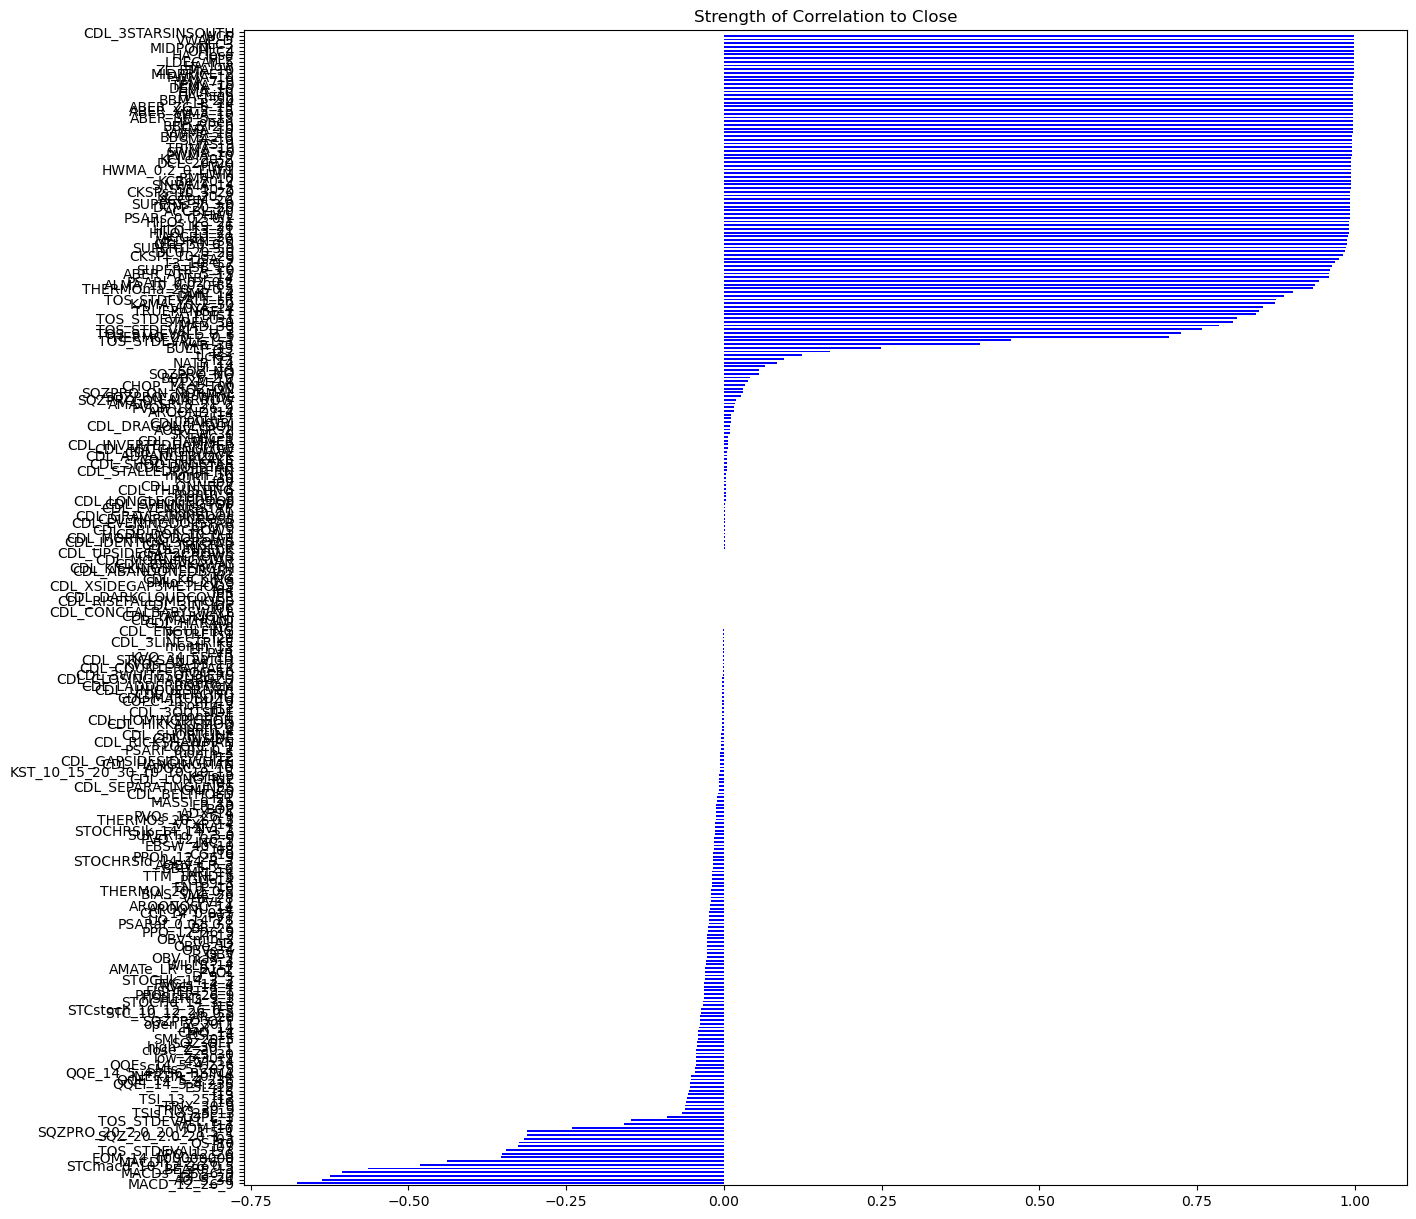

In [93]:
corr = df.corrwith(outcome_scaled['close_f1'],numeric_only=True)
corr.sort_values().plot.barh(color = 'blue',title = f'Strength of Correlation to Close',figsize=(15,15))

In [94]:
corr[corr.isna()]

CDL_3STARSINSOUTH   NaN
dtype: float64

In [96]:
for i in range(len(corr)):
    print(corr.index[i] , " : " , corr[i])

f01  :  -0.007246350318503996
f02  :  0.00021261991461039623
f03  :  -0.31718552485459306
f04  :  -4.672811785375882e-05
f05  :  -0.00013036812482765912
f06  :  -0.00022248839174557762
f07  :  -0.3268450595968834
f08  :  -0.016172137306176747
f09  :  0.003214180083129819
f10  :  -0.0005555532357810211
f11  :  -0.003138690560055241
f12  :  -0.006265467875162586
f13  :  -0.05740471898032937
f14  :  0.01087257054563602
f15  :  -0.033735580996753584
f16  :  -0.05997432615238716
f17  :  -0.15898757116876042
f18  :  -0.05487065842427617
f20  :  -0.0007440393289464295
f21  :  -0.010305028738882439
f22  :  0.16899758477194404
f23  :  0.09559444632151802
month_1  :  -0.0031706225062945784
month_2  :  -0.002474135357673338
month_3  :  -0.0030403004201015587
month_4  :  -0.003504793162284406
month_5  :  -0.005890535187289061
month_6  :  -0.003494763949909794
month_7  :  0.010822306448670497
month_8  :  0.002654672513925626
month_9  :  0.0026672158305145804
month_10  :  0.0035277789762698775
month

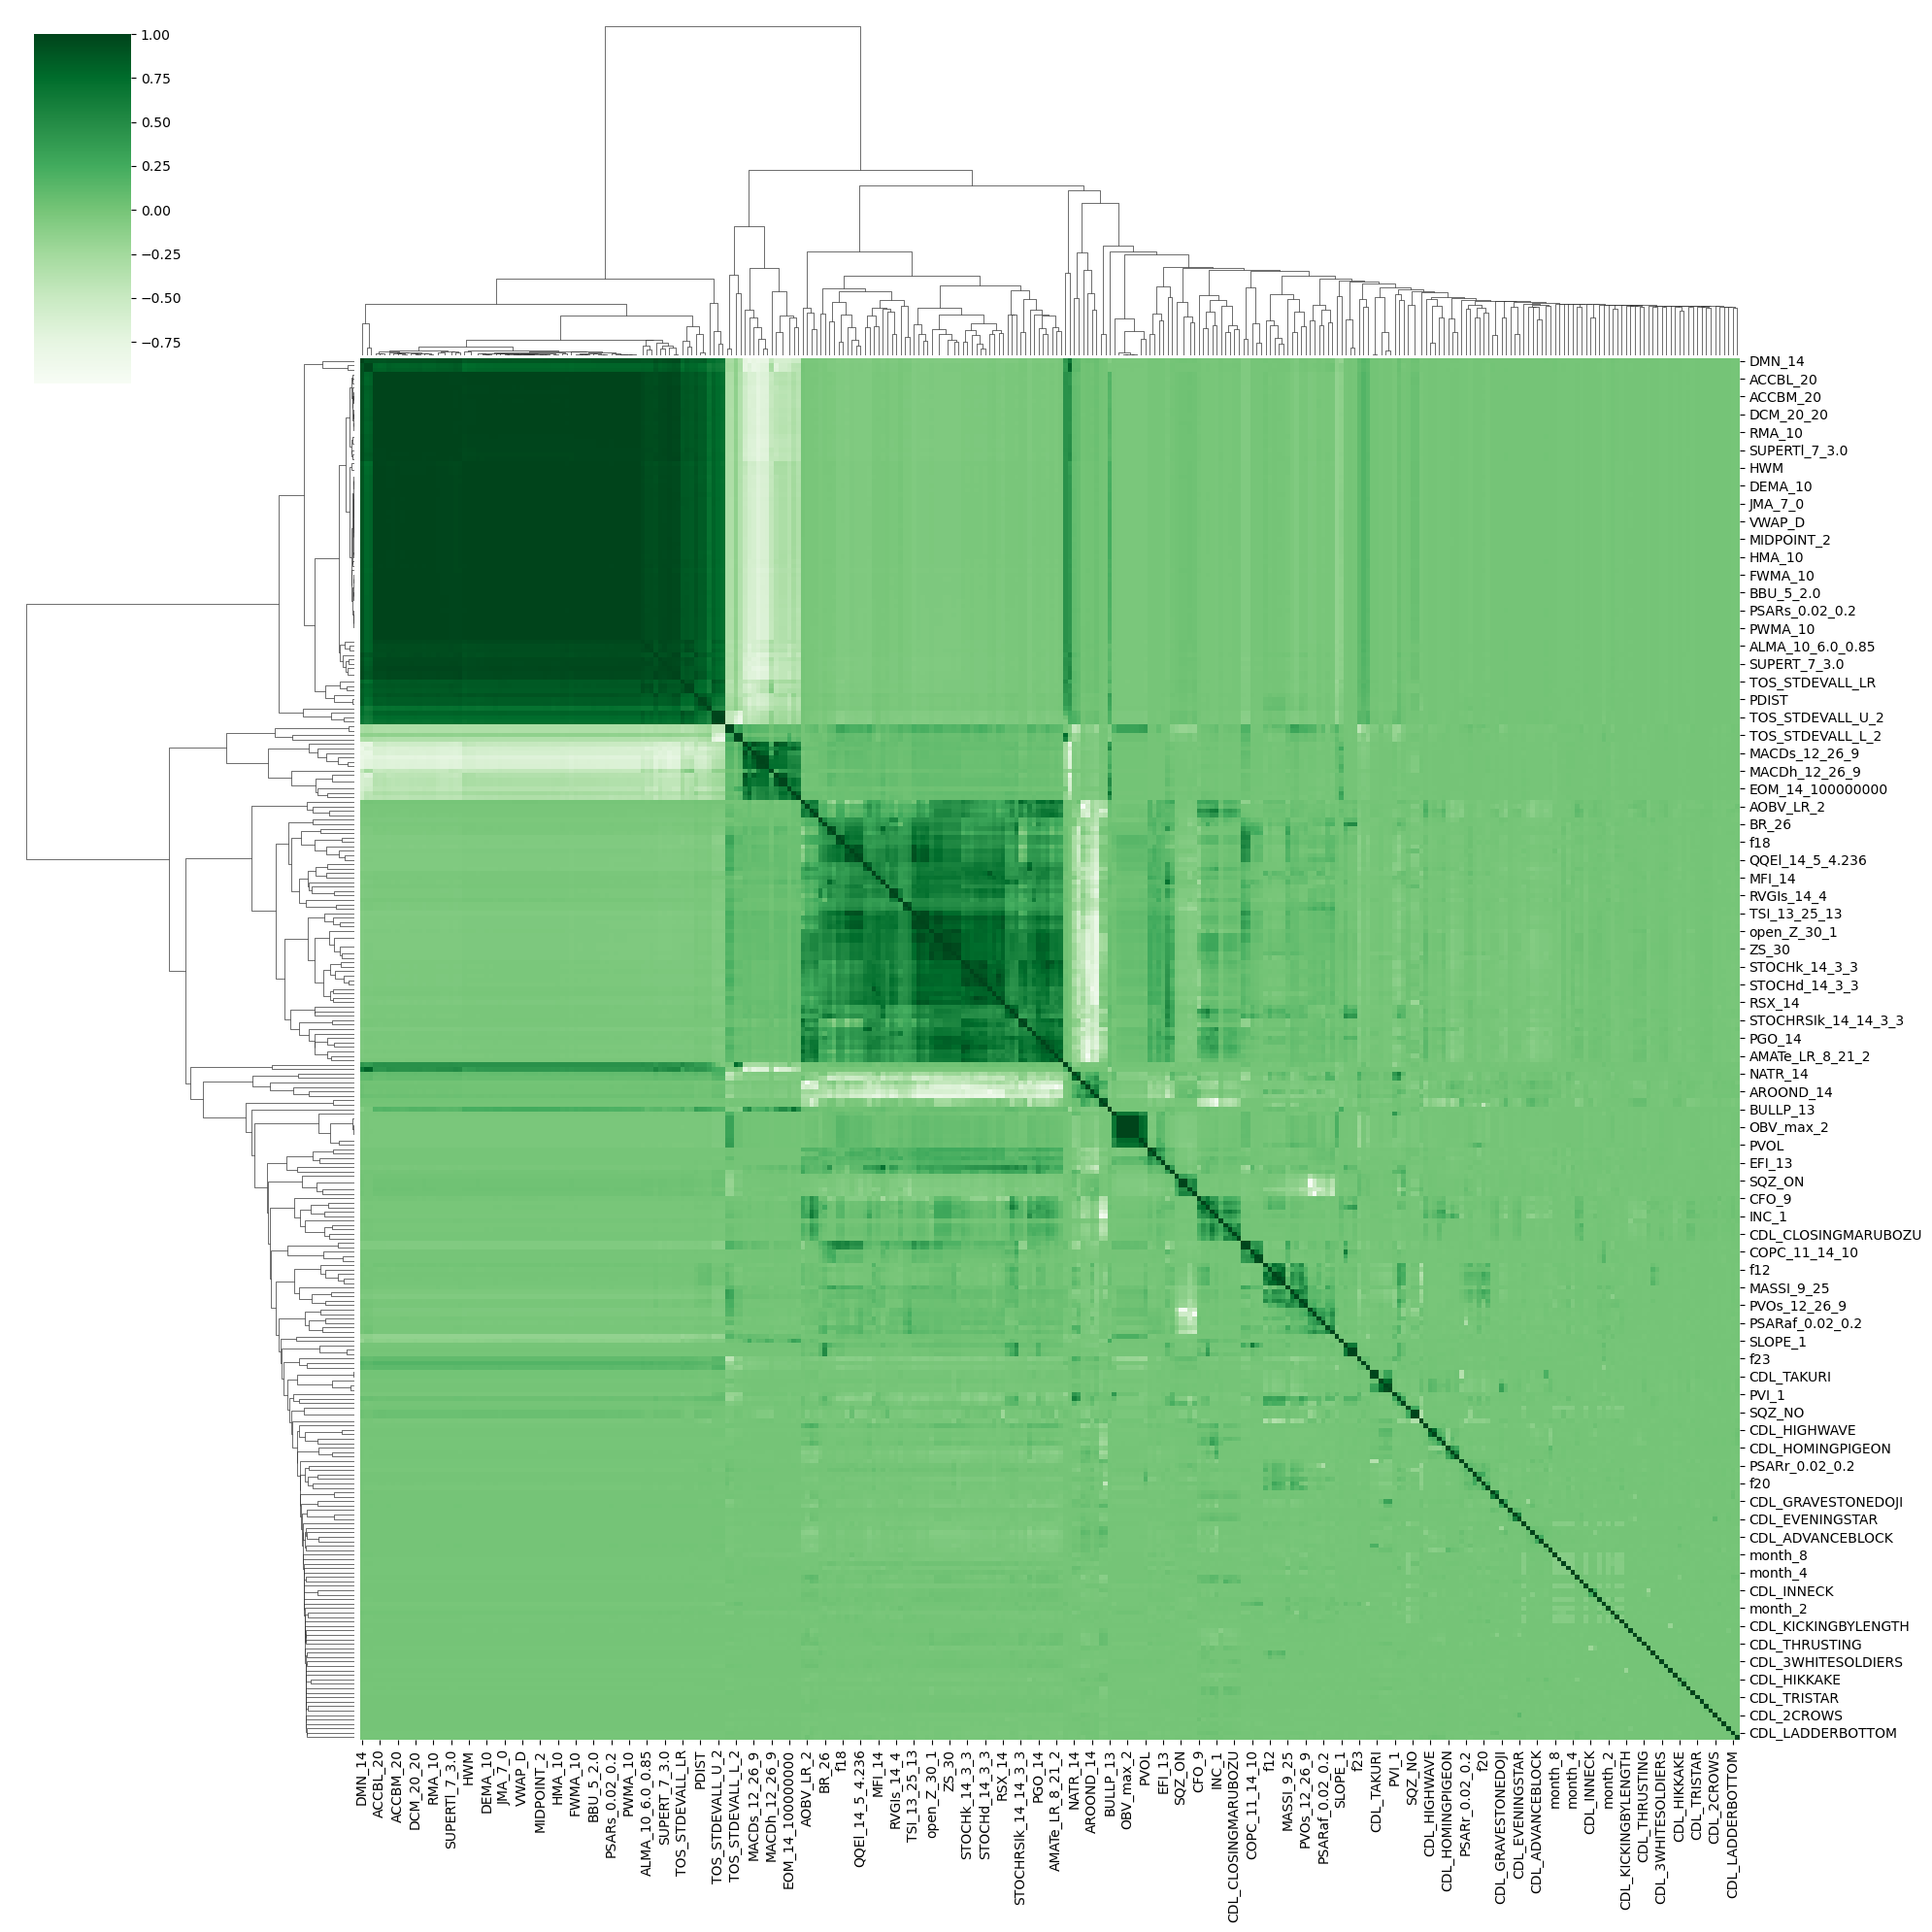

In [97]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

corr_matrix = df.corr().dropna(how='all', axis=1).dropna(how='all')
correlations_array = np.asarray(corr_matrix)

dist = distance.pdist(correlations_array)
linkage = hierarchy.linkage(dist,method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,row_cluster=True,col_cluster=True,figsize=(20,20),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
#plots a heatmap representation of a covariance matrix and runs a hierarchical clustering algorithm to group together the most closely related features.

In [98]:
THRESHOLD = 0.1
correlated_features = []

cols = ['close_f1','high_f1','low_f1','open_f1','close_f7','high_f7','low_f7','open_f7']
cols += ['close_f15','high_f15','low_f15','open_f15','close_f30','high_f30','low_f30','open_f30']
cols += ['close_f60','high_f60','low_f60','open_f60','close_f90','high_f90','low_f90','open_f90']
cols += ['close_f120','high_f120','low_f120','open_f120','close_f240','high_f240','low_f240','open_f240']
cols += ['close_f365','high_f365','low_f365','open_f365']

for col in cols:
    corr_df = df.corrwith(outcome_scaled[col],numeric_only=True)
    correlated = corr_df[corr_df>THRESHOLD].sort_values(ascending=False).index.tolist()
    for c in correlated:
        if c not in correlated_features:
            correlated_features.append(c)
    print("Done with: ", col)

Done with:  high_f1
Done with:  low_f1
Done with:  open_f1
Done with:  close_f7
Done with:  high_f7
Done with:  low_f7
Done with:  open_f7
Done with:  close_f15
Done with:  high_f15
Done with:  low_f15
Done with:  open_f15
Done with:  close_f30
Done with:  high_f30
Done with:  low_f30
Done with:  open_f30
Done with:  close_f60
Done with:  high_f60
Done with:  low_f60
Done with:  open_f60
Done with:  close_f90
Done with:  high_f90
Done with:  low_f90
Done with:  open_f90
Done with:  close_f120
Done with:  high_f120
Done with:  low_f120
Done with:  open_f120
Done with:  close_f240
Done with:  high_f240
Done with:  low_f240
Done with:  open_f240
Done with:  close_f365
Done with:  high_f365
Done with:  low_f365
Done with:  open_f365


Correlation Strength:
WCP           0.998734
VWAP_D        0.998696
HLC3          0.998669
MIDPOINT_2    0.998553
HA_close      0.998526
                ...   
VAR_30        0.405390
BULLP_13      0.249151
f22           0.168998
ticker        0.123463
f23           0.095594
Length: 88, dtype: float64


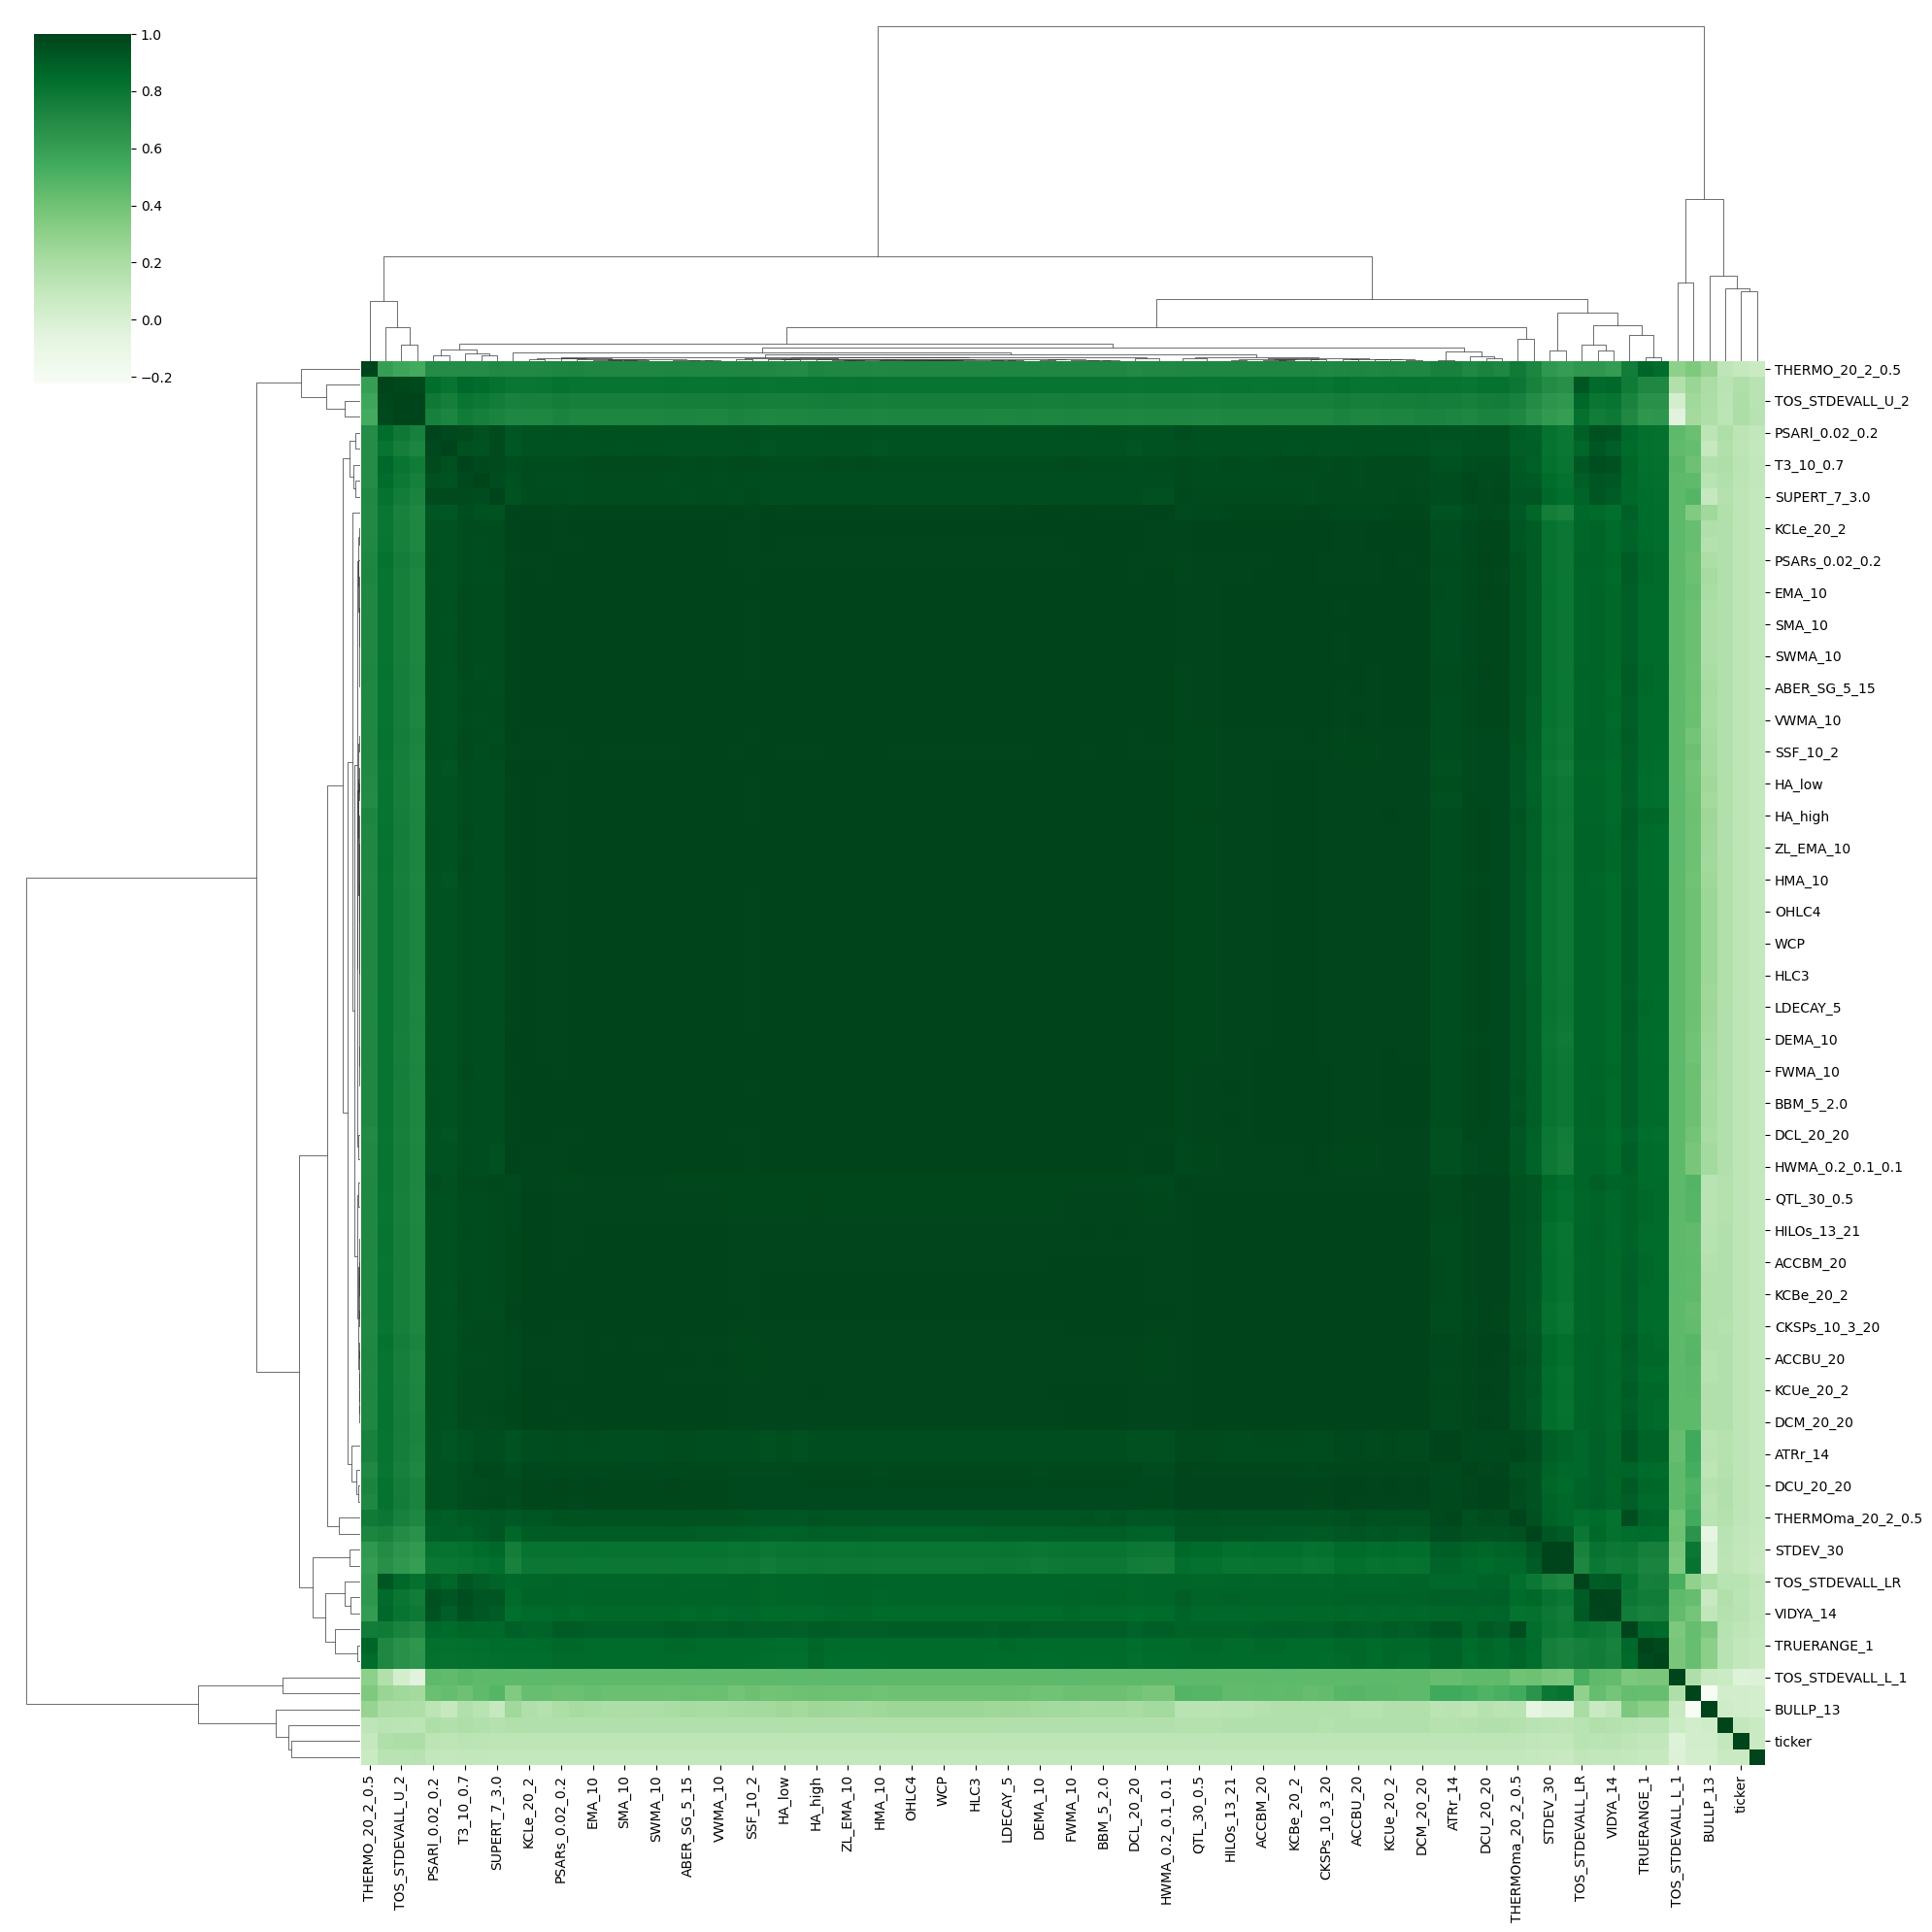

In [142]:
corr_matrix = df[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array),method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,row_cluster=True,col_cluster=True,figsize=(20,20),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength:")
print(corr[correlated_features].sort_values(ascending=False))

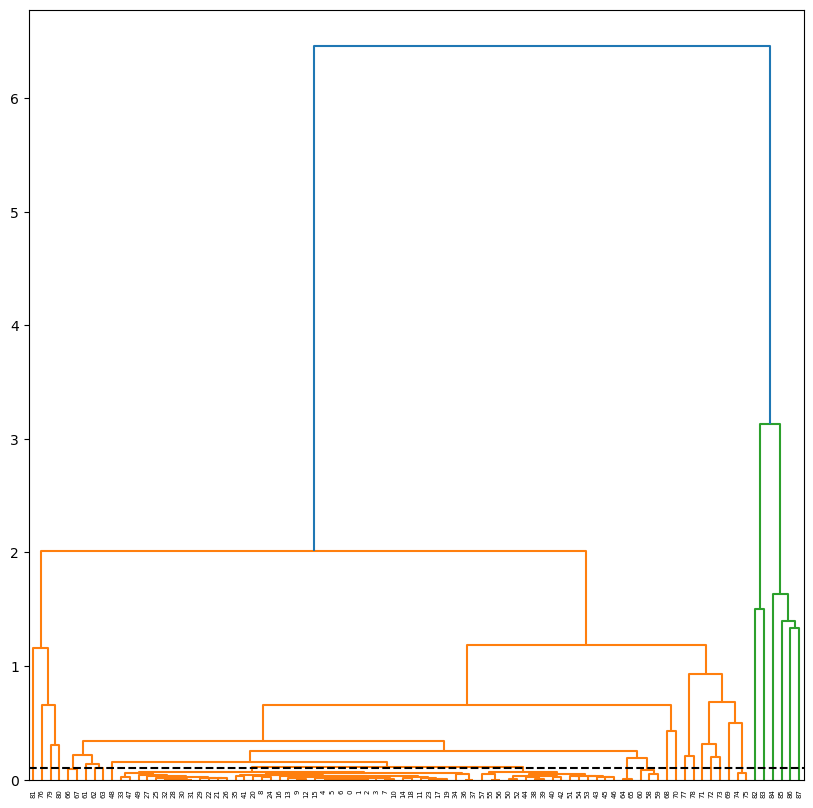

In [143]:
plt.figure(figsize=(10, 10))
p = hierarchy.dendrogram(linkage)
plt.axhline(0.1, color='k', ls='--')
plt.show()

In [144]:
"""
Step 1: Take the most strongly correlated feature and add it to our list of selected features. 
Step 2: Take the second correlated feature and check to see if it's closely correlated (in the clustermap) to any features already chosen. 
    If no, add to the list. 
    If yes, discard. Step 
3: Repeat this process until either (1) we've reached the target feature count, or (2) we've run out strongly correlated features.
"""

"\nStep 1: Take the most strongly correlated feature and add it to our list of selected features. \nStep 2: Take the second correlated feature and check to see if it's closely correlated (in the clustermap) to any features already chosen. \n    If no, add to the list. \n    If yes, discard. Step \n3: Repeat this process until either (1) we've reached the target feature count, or (2) we've run out strongly correlated features.\n"

In [145]:
dist = distance.pdist(correlations_array)

In [146]:
def create_selected_features(correlated_features,linkage, threshold, num_features=None):
    selected_features = []
    added_clusters = []
    clusters = hierarchy.fcluster(linkage, t=threshold, criterion='distance')
    name_cluster = {n:c for n,c in zip(correlated_features,clusters)}
    print(f"Creating {max(clusters)} Selected Features")
    for col,cluster in zip(correlated_features,clusters):
        if num_features is not None and len(selected_features) == num_features:
            break
        if cluster not in added_clusters:
            print(col,cluster)
            added_clusters.append(cluster)
            selected_features.append(col)
    
    return selected_features

In [147]:
sel_features = create_selected_features(correlated_features,linkage, 0.1)

Creating 28 Selected Features
WCP 9
RMA_10 10
HWL 11
DCU_20_20 13
T3_10_0.7 8
ISB_26 6
SUPERT_7_3.0 7
ABER_ATR_5_15 12
PSARl_0.02_0.2 5
THERMOma_20_2_0.5 14
DMP_14 22
DMN_14 15
TOS_STDEVALL_LR 20
KAMA_10_2_30 18
VIDYA_14 19
TRUERANGE_1 21
TOS_STDEVALL_U_1 3
STDEV_30 16
MAD_30 17
TOS_STDEVALL_U_2 1
TOS_STDEVALL_U_3 2
THERMO_20_2_0.5 4
TOS_STDEVALL_L_1 23
VAR_30 24
BULLP_13 28
f22 27
ticker 25
f23 26


In [148]:
size = len(sel_features)

In [149]:
selected_features = sel_features + feat_names

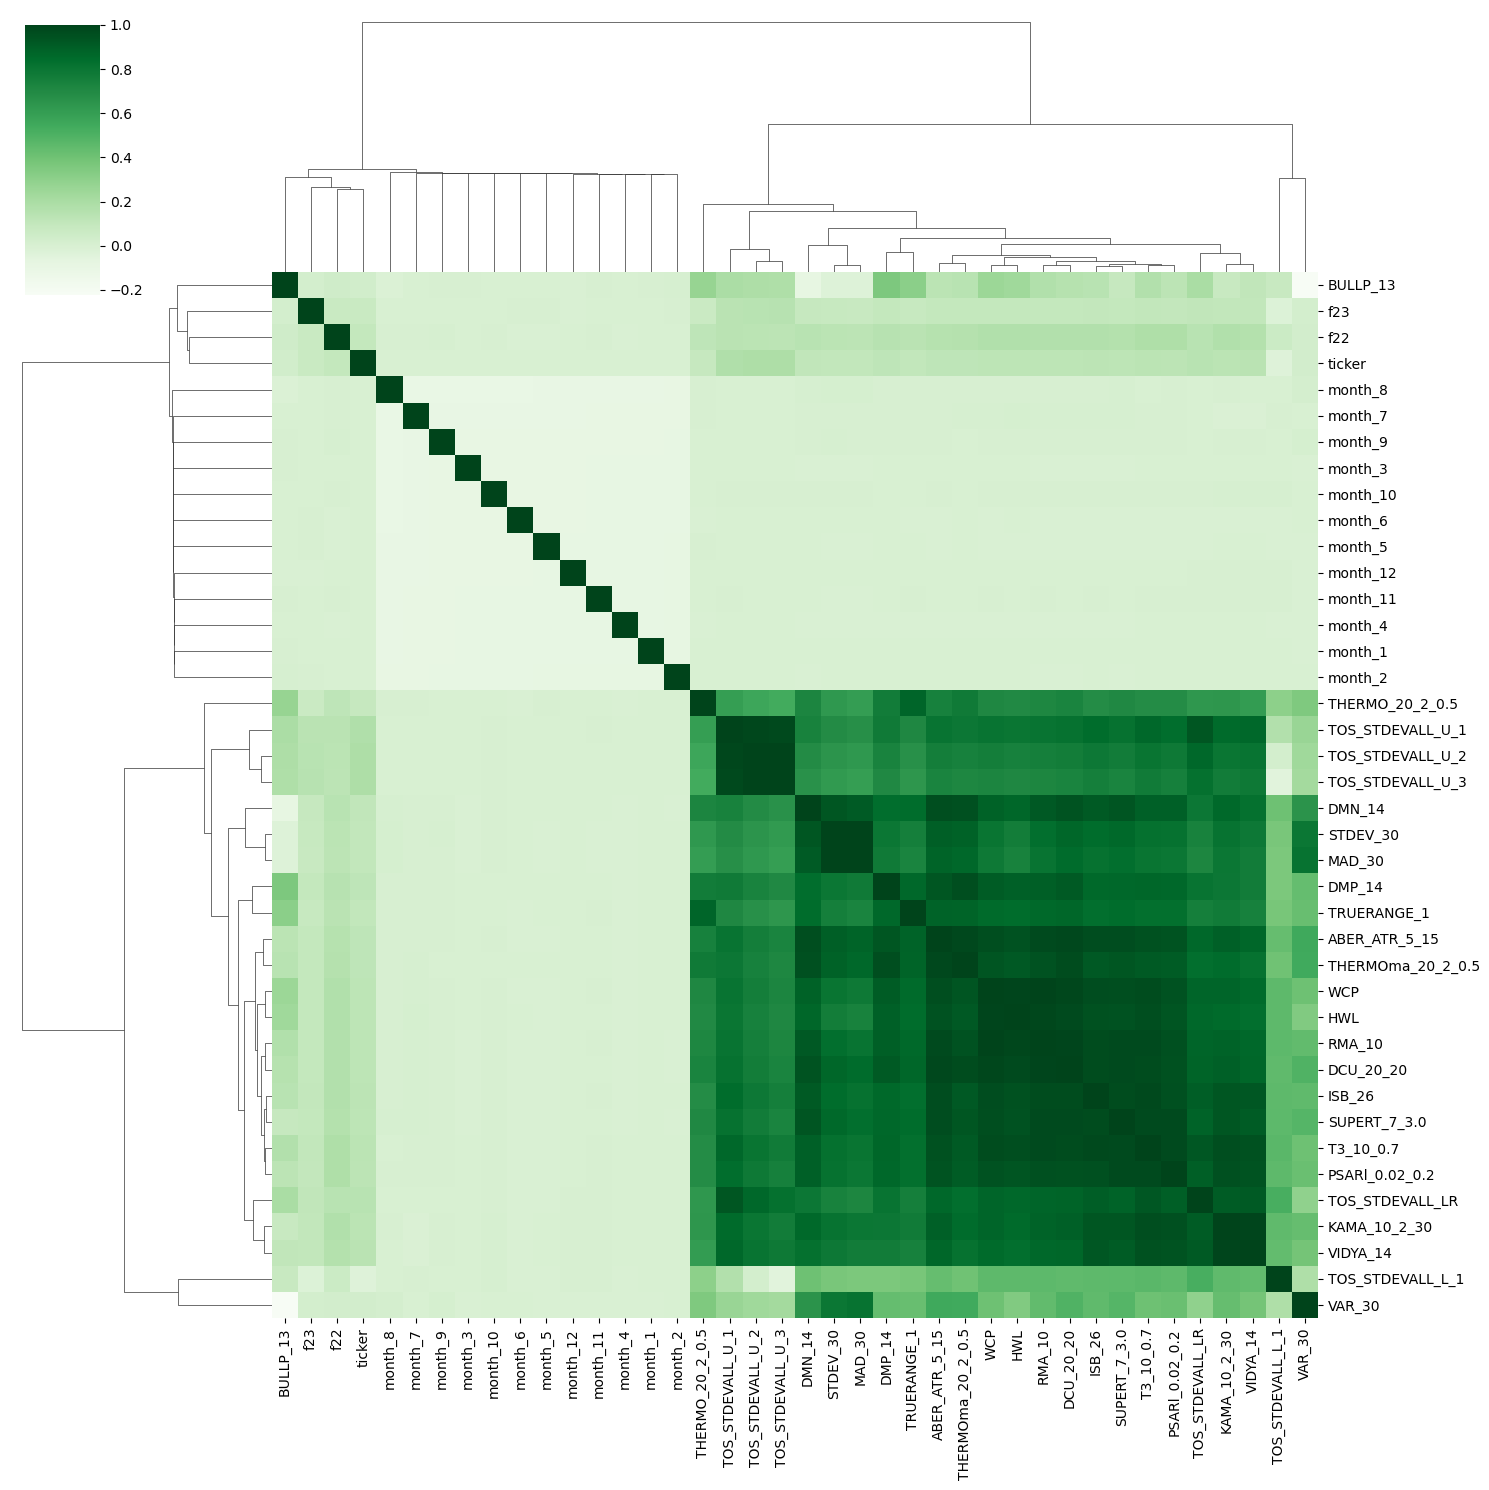

In [150]:
corr_matrix = df[selected_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage, row_cluster=True,col_cluster=True,figsize=(15,15),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

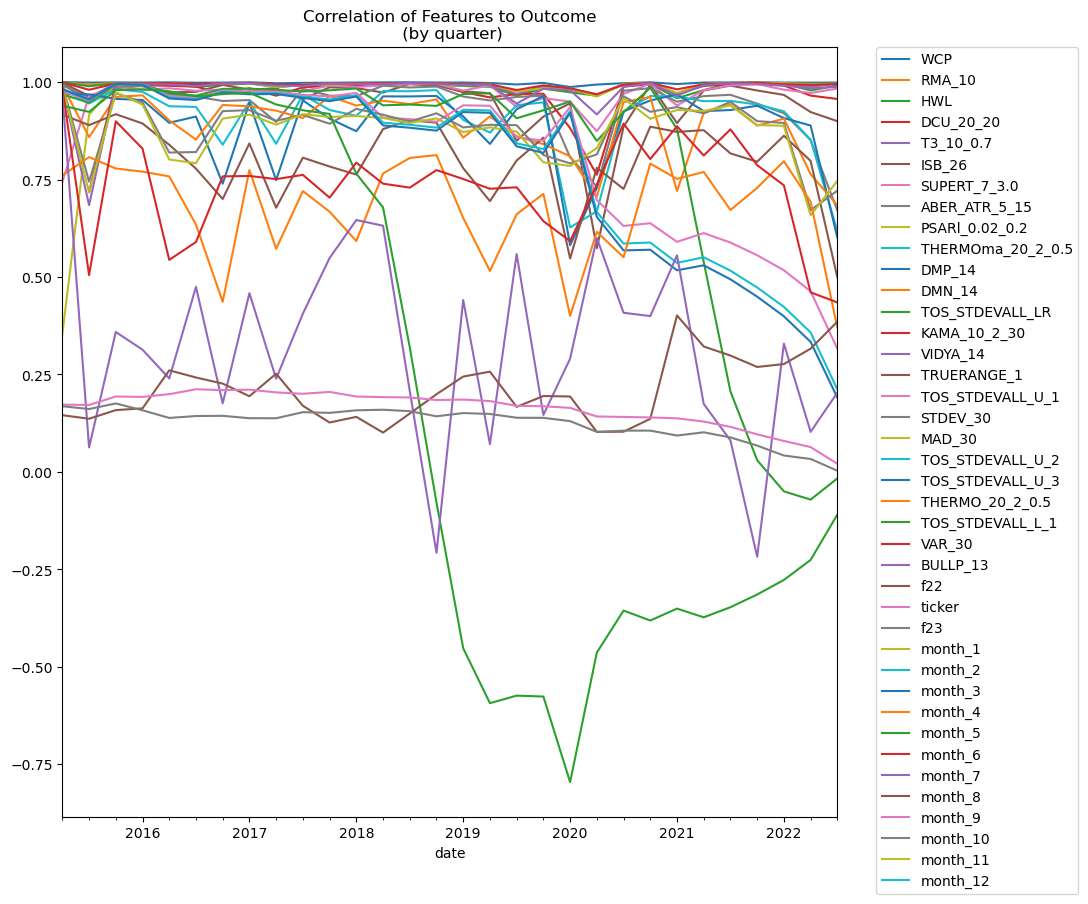

In [151]:
tmp = df[selected_features].join(outcome_scaled['close_f1']).reset_index().set_index('date')
tmp.dropna().resample('Q').apply(lambda x: pd.DataFrame(x).corr(numeric_only=True)).iloc[:,-1].unstack().iloc[:,:-1].plot(title='Correlation of Features to Outcome\n (by quarter)',figsize=(10,10))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)